# Spec2Vec - spectra networking
The aim of Spec2Vec is to represent each spectrum by an abstract, low-dimensional (typically 200-500 dimensional) vector which is able to capture the underlying molecular relationships between spectra.

One of the important envisioned use-cases for the Spec2Vec based spectra similarity measure, is **molecular networking**. Here we aim at clustering all spectra by building networks from nodes (=spectra) and their most prominent edges/connections (=most similar pairs of spectra).


## Notebook outline
1. Importing folders and packages
2. Import and filter MS-MS data from MGF file
3. Load model and find most similar spectra
4. Create network from modified cosine scores

In [1]:
import os
import sys
import gensim
import numpy as np
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\'
sys.path.insert(0, ROOT)

# 1. Import and filter MS-MS data from MGF file

### Loading MGF file
In the following the MGF file containing all spectra and metadata will be loaded. 
The MGF file was generated from all publich gnps libraries (state: April 2020). Spectra annotations were checked, cleaned, and extended where possible following a procedure described in another notebook: LINK HERE

### Spectra filtering
#### 1. Discard spectra with too few peaks.
Spectra with less than "min_peaks" peaks will be ignored. Here this is set to min_peaks = 10.  

#### 2. Filter out noise. 
This can be done by:
#### A) Exponential peak intensity filter 
Further filtering is done to reduce the level of noise in the spectra. For this we calculate a threshold (or minimum peak intensity) for every spectrum. Where possible (most cases), this threshold is calculated by doing an exponential fit to the peak intensity histogram ("exp_intensity_filter"). If that fails we take the mean intensity of all peaks but the highest as a threshold.  
**But keep enough information:** Aimed at similar sized documents: If the number of peaks above the set threshold is lower than $n_{aim}$ = min_peaks + peaks_per_mz * precursor_mass we will at least keep the highest $n_{aim}$ peaks.

#### B) Relative peak intensity filter
This is a simpler filter which will discard all peaks with an intensity < min_intensity_perc/100 * max_peak_intensity.

### Creation of documents from spectra
Peaks and losses (= precursor mass - peak mass) are converted into words using a precision of "num_decimals".  
A peak with m/z = 108.3643 will hence become a string: "peak_108.36".  
A loss with m/z = 64.2257 will hence become a string: "loss_64.23".  
All words of one spectrum are collected in one list which represents the entire spectrum as a 'document'.

In [2]:
from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_unique_inchikey_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))

number of spectra: 13717


In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import require_minimum_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import add_losses

def post_process(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# apply post processing steps to the data
spectrums_postprocessed = [post_process(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_postprocessed = [s for s in spectrums_postprocessed if s is not None]

In [35]:
len(spectrums_postprocessed)

12797

# 2. Load model and find most similar spectra

### Load pretrained Spec2Vec model

In [4]:
path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_UniqueInchikeys_ratio05_filtered_iter_50.model")

# Load pretrained model
model = gensim.models.Word2Vec.load(model_file)

### Calculate similarities between all spectra and get top 25 for each spectrum

In [5]:
# load already calculated scores
filename = os.path.join(path_data,'similarities_spec2vec_2dec_UniqueInchikeys_iter_50.npy')
matrix_similarities_spec2vec = np.load(filename)

In [6]:
# Create numpy arrays to store top similarities for each spectrum
def get_top_hits(matrix_similarities, top_n):
    """get top_n highest scores (and indices) for every entry."""
    similars_idx = np.zeros((matrix_similarities.shape[0], top_n), dtype=int)
    similars_scores = np.zeros((matrix_similarities.shape[0], top_n))
    for i in range(matrix_similarities_spec2vec.shape[0]):
        similars_idx[i,:] = matrix_similarities[i,:].argsort()[-top_n:][::-1]
        similars_scores[i,:] = matrix_similarities[i, similars_idx[i,:]]
    return similars_idx, similars_scores

top_n = 25
spec2vec_similars_idx, spec2vec_similars = get_top_hits(matrix_similarities_spec2vec, top_n)

In [7]:
spec2vec_similars_idx[0]

array([    0,   161,  1645,  1424,    98,    99,  1480,   842,  1602,
         159,  1857,   152,   190,   196,   202, 12773,   155,   290,
         187,   191,   186,   167,   792,     1,   151])

In [8]:
spec2vec_similars[0]

array([1.        , 0.53571951, 0.52118228, 0.49744866, 0.49586568,
       0.49078972, 0.48415176, 0.47132429, 0.46870286, 0.46561163,
       0.46273797, 0.45740108, 0.45349913, 0.44836881, 0.44414995,
       0.44193897, 0.44169558, 0.43467547, 0.43268013, 0.43132497,
       0.43131901, 0.43005181, 0.42887432, 0.42553656, 0.42146296])

## Import reference matrix of all-vs-all molecular similarity values
Similarities based on molecular fingerprints. See other notebook on how those scores are derived:
**add here**

In [10]:
filename = os.path.join(path_data, 'similarities_daylight2048_jaccard.npy')
matrix_similarities_ref = np.load(filename)

In [21]:
np.any(np.isnan(matrix_similarities_ref))

True

In [45]:
nan_idx = np.argwhere(np.isnan(matrix_similarities_ref[:,1]))
nan_idx

array([[ 543],
       [1246]], dtype=int64)

In [11]:
matrix_similarities_ref[np.isnan(matrix_similarities_ref)] = 0

In [80]:
def histogram_scores(scores, n_bins):
    """ Create histogram and plot it.
    """
    bins_lst = np.linspace(0, 1, n_bins+1) 
    plt.style.use('default') #('ggplot')
    plt.figure(figsize=(8,7))
    
    hist, bin_edges = np.histogram(scores, bins_lst)
    
    bar_width = 0.8 * 1/n_bins
    plt.bar(bin_edges[:-1], 100*hist/np.sum(hist), width = bar_width, color='none', edgecolor='gray', hatch="///", lw=2., zorder = 0)
    plt.bar(bin_edges[:-1], 100*hist/np.sum(hist), width = bar_width, edgecolor='black', linewidth=3, color='none',alpha=1)
    
    maxbar = np.max(100*hist/np.sum(hist))
    plt.yticks(10*np.arange(np.ceil(maxbar/10)), ["{}".format(10*x) for x in np.arange(np.ceil(maxbar/10))], fontsize=12)
    
    bar_labels = ['{:03.1f} - {:03.1f}'.format(bins_lst[i], bins_lst[i+1]) for i in range(n_bins)]
    plt.xticks(bins_lst[:-1], bar_labels, fontsize=12, rotation='vertical')
    plt.xlabel('molecular similarity (Tanimoto)', fontsize=16)
    plt.ylabel('fraction of all scores [%]', fontsize=16)
        
    return hist, bin_edges

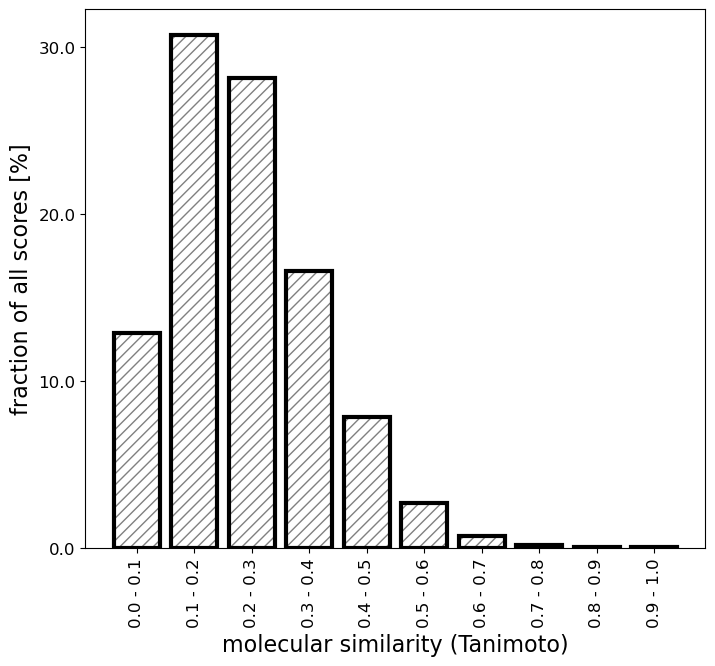

In [82]:
hist, bin_edges = histogram_scores(matrix_similarities_ref, n_bins=10)

plt.savefig("histogram_structural_similarities.pdf", bbox_inches='tight')

In [84]:
hist/np.sum(hist)

array([0.12903969, 0.30756539, 0.28178446, 0.16578625, 0.07859659,
       0.02683478, 0.00698549, 0.00192572, 0.00084371, 0.00063791])

---

## Create and trim the network

This will require further libraries. 
```
pip install networkx==2.3
pip install python-louvain
```

### Import network functions

In [12]:
import custom_functions.networking as net
from custom_functions.networking import plot_clustering_performance, plots_cluster_evaluations
import networkx as nx

# 3. Create network from modified cosine scores

### Import all-vs-all matrix of modified cosine scores.
Derived in separate notebook:  ...

In [13]:
filename = os.path.join(path_data,'similarities_mod_cosine_tol0005.npy')
matrix_similarities_mod_cosine = np.load(filename)

filename = os.path.join(path_data,'similarities_mod_cosine_tol0005_matches.npy')
matrix_matches_mod_cosine = np.load(filename)

## Modified cosine score networking (basic setting)
### tol = 0.005, min_match = 1

In [14]:
top_n = 25
modcos_similars_idx, modcos_similars = get_top_hits(matrix_similarities_mod_cosine, top_n)

In [15]:
MSnets_modcos = []
DATA_modcos = []
DATA_modcos_louvain = []
thresholds = [0.6, 0.7, 0.8, 0.9, 0.95]

# Create network for different cutoff thresholds:
for thres in thresholds:
    MSnets_modcos.append(net.create_network(modcos_similars_idx,
                                            modcos_similars,
                                            max_links = 10,
                                            cutoff = thres,
                                            link_method = 'single'))
    
for network in MSnets_modcos:
    cluster_data = net.evaluate_clusters(network, matrix_similarities_ref)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network, matrix_similarities_ref, resolution = 1.0)
    
    DATA_modcos.append(cluster_data)
    DATA_modcos_louvain.append(cluster_data_louvain)

In [16]:
DATA_modcos[0]

,num_nodes,num_edges,ref_sim_mean_edges,ref_sim_var_edges,ref_sim_mean_nodes,ref_sim_var_nodes
0,1,0,0.000000,0.000000,1.000000,0.000000
1,1,0,0.000000,0.000000,1.000000,0.000000
2,8062,38422,0.451517,0.077751,0.237979,0.016172
3,3,3,0.194628,0.008051,0.463086,0.149506
4,1,0,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...
3933,1,0,0.000000,0.000000,1.000000,0.000000
3934,1,0,0.000000,0.000000,1.000000,0.000000
3935,1,0,0.000000,0.000000,1.000000,0.000000
3936,1,0,0.000000,0.000000,1.000000,0.000000


c:\users\florianhuber\anaconda3\envs\spec2vec_analysis\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\florianhuber\anaconda3\envs\spec2vec_analysis\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(-1.0, 6.8)

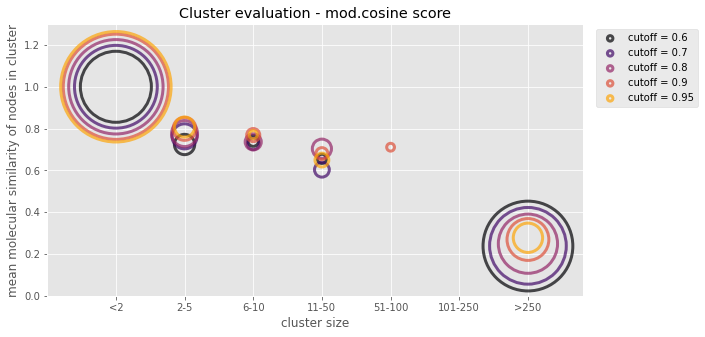

In [18]:
total_num_nodes = len(spectrums)

size_bins = [1,5,10,50,100,250, len(spectrums)]
labels_modcos = ['cutoff = {}'.format(x) for x in thresholds]

plots_cluster_evaluations(DATA_modcos,
                              matrix_similarities_ref,
                              total_num_nodes,
                              size_bins,
                              labels_modcos,
                              title = 'Cluster evaluation - mod.cosine score',
                              filename = 'modcos_min_match1_cluster_evaluation.pdf')
plt.ylim([0.0,1.3])
plt.xlim([-1, 6.8])

c:\users\florianhuber\anaconda3\envs\spec2vec_analysis\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\florianhuber\anaconda3\envs\spec2vec_analysis\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(-1.0, 6.8)

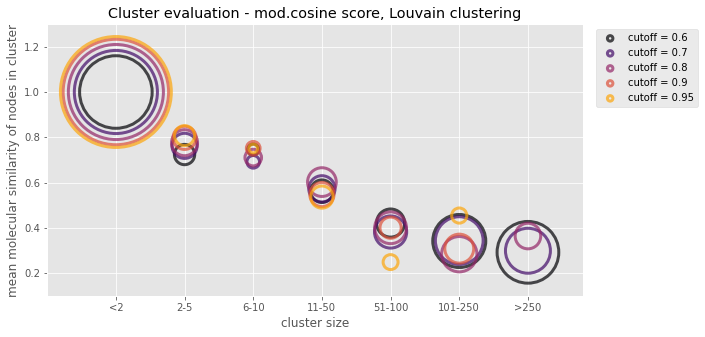

In [62]:
size_bins = [1,5,10,50,100,250, len(spectrums)]
labels_modcos = ['cutoff = {}'.format(x) for x in thresholds]

plots_cluster_evaluations(DATA_modcos_louvain,
                          matrix_similarities_ref,
                          total_num_nodes,
                          size_bins,
                          labels_modcos,
                          title = 'Cluster evaluation - mod.cosine score, Louvain clustering',
                          filename = 'modcos_min_match1_louvain_cluster_evaluation.pdf')
plt.ylim([0.1,1.3])
plt.xlim([-1, 6.8])

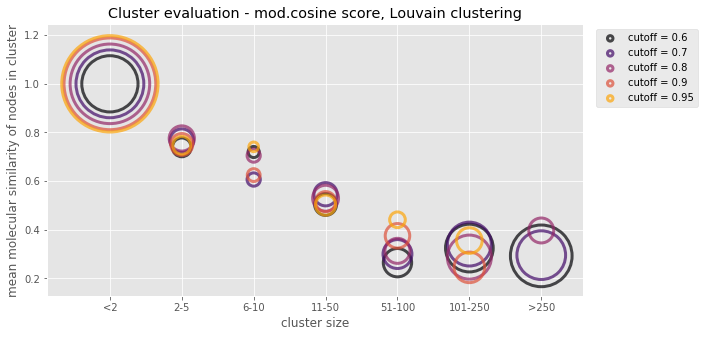

In [28]:
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_modcos = ['cutoff = {}'.format(x) for x in thresholds]

plots_cluster_evaluations(DATA_modcos_louvain,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_modcos,
                              title = 'Cluster evaluation - mod.cosine score, Louvain clustering',
                              filename = 'modcos_min_match1_louvain_cluster_evaluation.pdf')

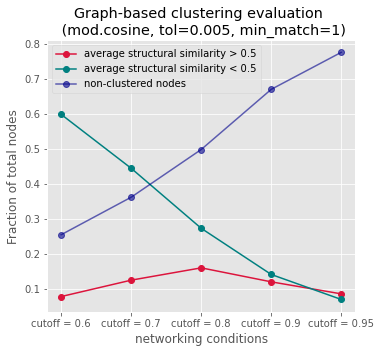

In [19]:
#plt.figure(figsize=(6,6))
title = 'Graph-based clustering evaluation \n (mod.cosine, tol=0.005, min_match=1)'
plot_clustering_performance(DATA_modcos,
                            labels_modcos,
                            total_num_nodes,
                            thres_well = 0.5,
                            thres_poor = 0.5,
                            title = title,
                            filename = 'modcos_min_match1_cluster_performance_thres05.pdf')

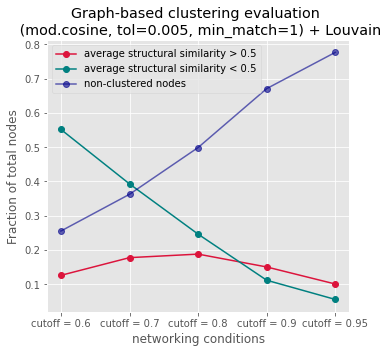

In [20]:
title = 'Graph-based clustering evaluation \n (mod.cosine, tol=0.005, min_match=1) + Louvain'
plot_clustering_performance(DATA_modcos_louvain,
                            labels_modcos,
                            total_num_nodes,
                            thres_well = 0.5,
                            thres_poor = 0.5,
                            title = title,
                            filename = 'modcos_min_match1_louvain_cluster_performance_thres05.pdf')

In [38]:
DATA_modcos_louvain[2]

,num_nodes,ref_sim_mean_nodes,ref_sim_var_nodes
0,1,1.0,0.0
1,1,1.0,0.0
2,1,1.0,0.0
3,1,1.0,0.0
4,1,1.0,0.0
...,...,...,...
8228,1,1.0,0.0
8229,1,1.0,0.0
8230,1,1.0,0.0
8231,1,1.0,0.0


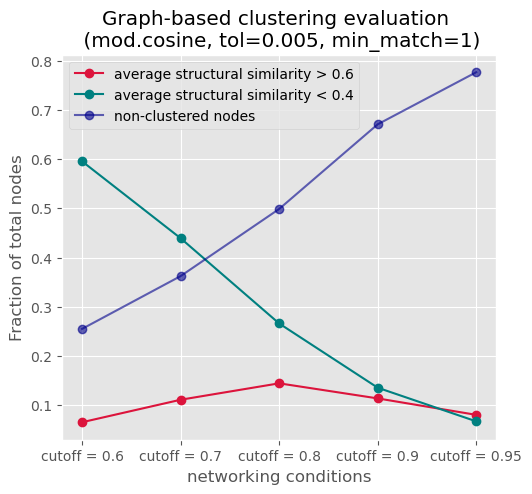

In [109]:
#plt.figure(figsize=(6,6))
title = 'Graph-based clustering evaluation \n (mod.cosine, tol=0.005, min_match=1)'
plot_clustering_performance(DATA_modcos,
                            labels_modcos,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'modcos_min_match1_cluster_performance.pdf')


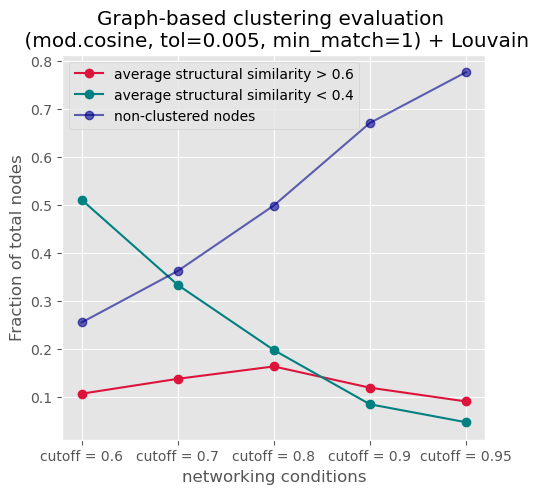

In [110]:
title = 'Graph-based clustering evaluation \n (mod.cosine, tol=0.005, min_match=1) + Louvain'
plot_clustering_performance(DATA_modcos_louvain,
                            labels_modcos,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'modcos_min_match1_louvain_cluster_performance.pdf')

### Graph creation based on top max_links similarities
Add up to max_links links per node if those have similarities > cutoff.

In [14]:
MSnet = net.create_network(MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_links = 10,
                           cutoff = 0.8,
                           link_method = 'single')

In [15]:
MSnet[10997]

AtlasView({4873: {'weight': 0.8130197878533513}, 5149: {'weight': 0.804400561065505}, 10996: {'weight': 0.9440537946305146}})

In [16]:
cluster_data = net.evaluate_clusters(MSnet,
                                     M_sim_mol)

In [17]:
cluster_data.head()

,num_nodes,num_edges,ref_sim_mean_edges,ref_sim_var_edges,ref_sim_mean_nodes,ref_sim_var_nodes
0,1,0,0.000000,0.000000,1.000000,0.000000
1,4212,16804,0.549537,0.085294,0.262253,0.020447
2,1,0,0.000000,0.000000,1.000000,0.000000
3,1,0,0.000000,0.000000,1.000000,0.000000
4,1,0,0.000000,0.000000,1.000000,0.000000


## Modified cosine score networking (more optimal setting)
### tol = 0.005, min_match = 10

In [21]:
top_n = 10

# Take mod.cosine scores and set scores to 0 for <10 matches
matrix_similarities_mod_cosine10 = matrix_similarities_mod_cosine.copy()
matrix_similarities_mod_cosine10[matrix_matches_mod_cosine < 10] = 0

modcos_similars_idx, modcos_similars = get_top_hits(matrix_similarities_mod_cosine10, top_n)

### Create networks for different cutoffs

In [29]:
MSnets_modcos = []
DATA_modcos = []
DATA_modcos_louvain = []
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

for thres in thresholds:
    MSnets_modcos.append(net.create_network(modcos_similars_idx,
                                           modcos_similars,
                                           max_links = 10,
                                           cutoff = thres,
                                           link_method = 'single'))
    
for network in MSnets_modcos:
    cluster_data = net.evaluate_clusters(network, matrix_similarities_ref)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network, matrix_similarities_ref, resolution = 1.0)
    
    DATA_modcos.append(cluster_data)
    DATA_modcos_louvain.append(cluster_data_louvain)

### Plot cluster sizes (for simple, unprocessed network)

c:\users\florianhuber\anaconda3\envs\spec2vec_analysis\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\florianhuber\anaconda3\envs\spec2vec_analysis\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(-1.0, 6.8)

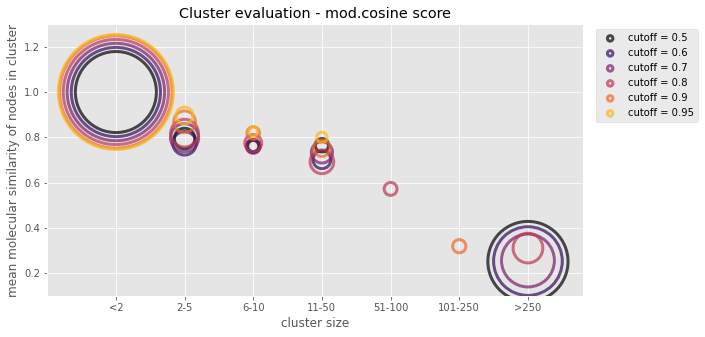

In [30]:
total_num_nodes = len(spectrums)
size_bins = [1,5,10,50,100,250, len(spectrums)]
labels_modcos = ['cutoff = {}'.format(x) for x in thresholds]

plots_cluster_evaluations(DATA_modcos,
                          matrix_similarities_ref,
                          total_num_nodes,
                          size_bins,
                          labels_modcos,
                          title = 'Cluster evaluation - mod.cosine score',
                          filename = 'modcos_min_match10_cluster_evaluation.pdf')

plt.ylim([0.1,1.3])
plt.xlim([-1, 6.8])

### Plot cluster sizes (using Louvain algorithm)

c:\users\florianhuber\anaconda3\envs\spec2vec_analysis\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\florianhuber\anaconda3\envs\spec2vec_analysis\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


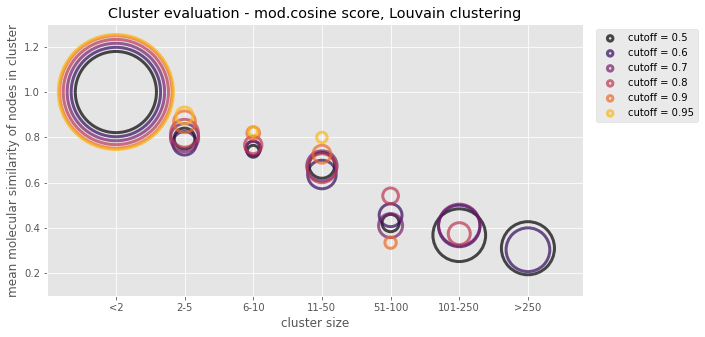

In [31]:
size_bins = [1,5,10,50,100,250, len(spectrums)]
labels_modcos = ['cutoff = {}'.format(x) for x in thresholds]

plots_cluster_evaluations(DATA_modcos_louvain,
                          matrix_similarities_ref,
                          total_num_nodes,
                          size_bins,
                          labels_modcos,
                          title = 'Cluster evaluation - mod.cosine score, Louvain clustering',
                          filename = 'modcos_min_match10_louvain_cluster_evaluation.pdf')

plt.ylim([0.1,1.3])
plt.xlim([-1, 6.8])
plt.savefig('modcos_min_match10_louvain_cluster_evaluation.pdf')

### Evalute quality of clusters
This is here done by classifying clusters with a average molecular similarity score <0.4 as poor. And clusters with a a mean molecular similariy > 0.6 as well clustered.

In [55]:
def plot_clustering_performance(data_collection,
                                labels,
                                thres_well=0.5,
                                thres_poor=0.5,
                                title=None,
                                filename=None,
                                size_xy=(8, 5)):
    """ Plot cluster evaluations for all conditions found in data_collection.
    Cluster will be classified as "well clustered" if the mean(similarity) across
    all nodes is > thres_well. Or as "poorly clustered" if < thres_poor.
    Clusters with only one node (singletons) will be counted as "non-clustered".

    Args:
    --------
    data_collection: list of pandas.DataFrame()
        List of DataFrames as created by evaluate_clusters().
    labels: list
        List of labels for the different conditions found in data_collection.
    thres_well: float
        Threshold above which clusters will be classified as "well clustered". Default = 0.5.
    thres_poor: float
        Threshold below which clusters will be classified as "poorly clustered". Default = 0.5.
    title: str
        Title for plot. Default = None
    filename: str
        If not none: save figure to file with given name.
    size_xy: tuple
        Figure size. Default is (8,5).
    """
    plt.style.use('ggplot')
    performance_data = []
    ymax = np.sum(data_collection[0]['num_nodes'].values) # total_num_nodes
    legend_labels = [
        "average structural similarity >= {:.2}".format(thres_well),
        "average structural similarity < {:.2}".format(thres_poor),
        'non-clustered nodes'
    ]

    for cluster_data in data_collection:
        nodes_clustered_well = np.sum(
            cluster_data[(cluster_data['num_nodes'] > 1)
                         & (cluster_data['ref_sim_mean_nodes'] >= thres_well)]
            ['num_nodes'].values)
        nodes_clustered_poor = np.sum(
            cluster_data[(cluster_data['num_nodes'] > 1)
                         & (cluster_data['ref_sim_mean_nodes'] < thres_poor)]
            ['num_nodes'].values)
        nodes_not_clustered = np.sum(
            cluster_data[(cluster_data['num_nodes'] < 2)]['num_nodes'].values)

        performance_data.append(
            [nodes_clustered_well, nodes_clustered_poor, nodes_not_clustered])

    fig = plt.figure(figsize=size_xy)
    ax = plt.subplot(111)
    ax.set_aspect(aspect=5)
    plt.plot(labels, [x[0] / ymax for x in performance_data],
             'o-',
             color='crimson',
             label=legend_labels[0])
    plt.plot(labels, [x[1] / ymax for x in performance_data],
             'o-',
             color='teal',
             label=legend_labels[1])
    plt.plot(labels, [x[2] / ymax for x in performance_data],
             'o-',
             color='darkblue',
             alpha=0.6,
             label=legend_labels[2])
    plt.title(title)
    plt.ylabel("Fraction of total nodes")
    plt.xlabel("networking conditions")
    plt.legend()

    # Place legend
    # chartbox = ax.get_position()
    # ax.set_position([chartbox.x0, chartbox.y0, chartbox.width*0.8, chartbox.height])
    # ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1))

    # Save figure to file
    if filename is not None:
        plt.savefig(filename, dpi=600)

12797


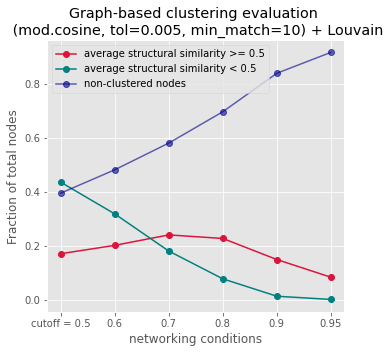

In [54]:
title = 'Graph-based clustering evaluation \n (mod.cosine, tol=0.005, min_match=10) + Louvain'
plot_clustering_performance(DATA_modcos_louvain,
                            labels_modcos,
                            thres_well = 0.5,
                            thres_poor = 0.5,
                            title = title,
                            filename = 'modcos_min_match10_louvain_cluster_performance_thres05.pdf')

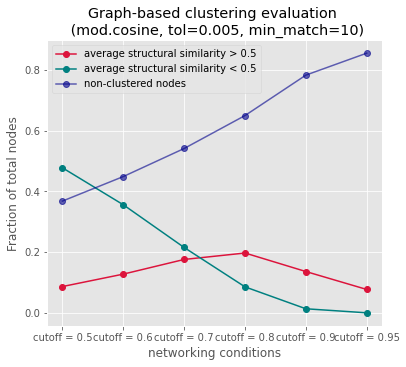

In [32]:
title = 'Graph-based clustering evaluation \n (mod.cosine, tol=0.005, min_match=10)'
plot_clustering_performance(DATA_modcos,
                            labels_modcos,
                            total_num_nodes,
                            thres_well = 0.5,
                            thres_poor = 0.5,
                            title = title,
                            filename = 'modcos_min_match10_cluster_performance_thres05.pdf',
                            size_xy = (6,6))

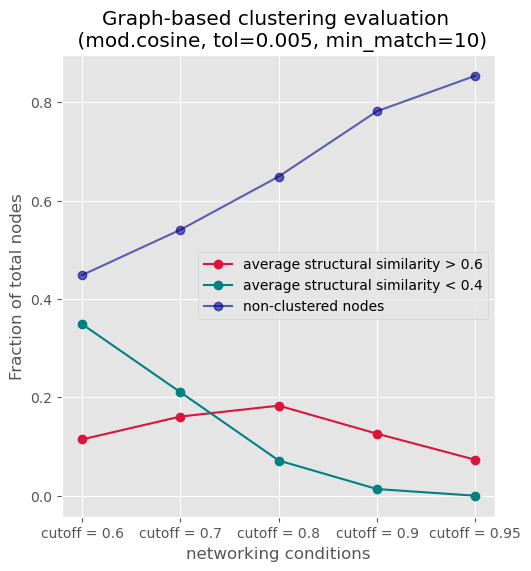

In [119]:
title = 'Graph-based clustering evaluation \n (mod.cosine, tol=0.005, min_match=10)'
plot_clustering_performance(DATA_modcos,
                            labels_modcos,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'modcos_min_match10_cluster_performance.pdf',
                            size_xy = (6,6))

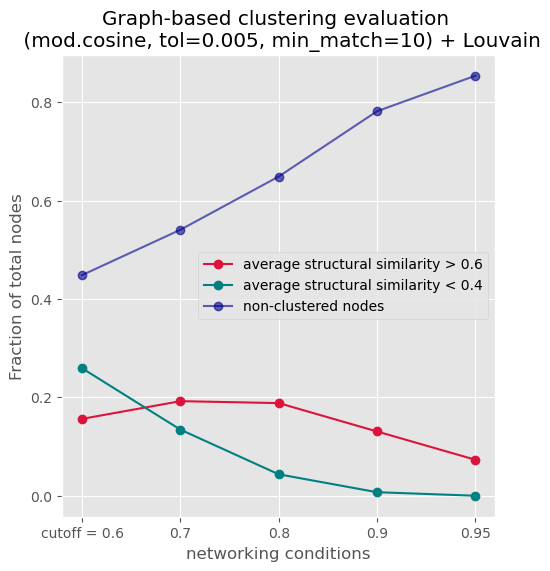

In [120]:
thresholds = [0.6, 0.7, 0.8, 0.9, 0.95]
title = 'Graph-based clustering evaluation \n (mod.cosine, tol=0.005, min_match=10) + Louvain'
labels_modcos = ['cutoff = ' + str(thresholds[0])] + [str(x) for x in thresholds[1:]]

plot_clustering_performance(DATA_modcos_louvain,
                            labels_modcos,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'modcos_min_match10_louvain_cluster_performance.pdf',
                           size_xy = (6,6))

---
# 5. Create network from Spec2Vec similarities

### Create networks for different Spev2Vec similarity cutoffs

In [25]:
MSnets_s2v = []
DATA_s2v = []
DATA_s2v_louvain = []
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

for thres in thresholds:
    MSnets_s2v.append(net.create_network(spec2vec_similars_idx,
                                         spec2vec_similars,
                                         max_links = 10,
                                         cutoff = thres,
                                         link_method = 'single'))
    
for network in MSnets_s2v:
    cluster_data = net.evaluate_clusters(network, matrix_similarities_ref)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network, matrix_similarities_ref, resolution = 1.0)
    
    DATA_s2v.append(cluster_data)
    DATA_s2v_louvain.append(cluster_data_louvain)

c:\users\florianhuber\anaconda3\envs\spec2vec_analysis\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\florianhuber\anaconda3\envs\spec2vec_analysis\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


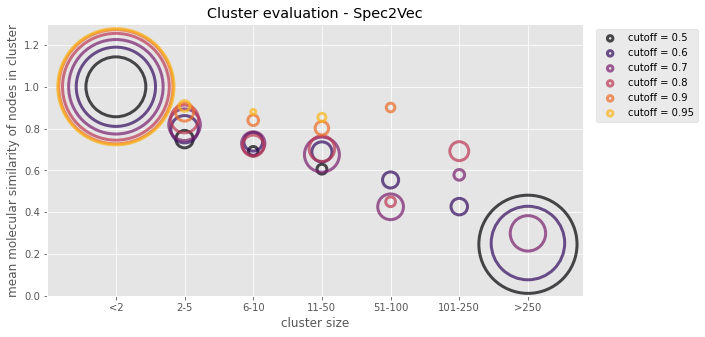

In [26]:
size_bins = [1,5,10,50,100,250, len(spectrums)]
labels_s2v = ['cutoff = ' + str(x) for x in thresholds]

plots_cluster_evaluations(DATA_s2v,
                          matrix_similarities_ref,
                          total_num_nodes,
                          size_bins,
                          labels_s2v,
                          title = 'Cluster evaluation - Spec2Vec',
                          filename = 'S2V_cluster_evaluation.pdf')

plt.ylim([0.0,1.3])
plt.xlim([-1, 6.8])
plt.savefig('S2V_cluster_evaluation.pdf')

c:\users\florianhuber\anaconda3\envs\spec2vec_analysis\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\florianhuber\anaconda3\envs\spec2vec_analysis\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


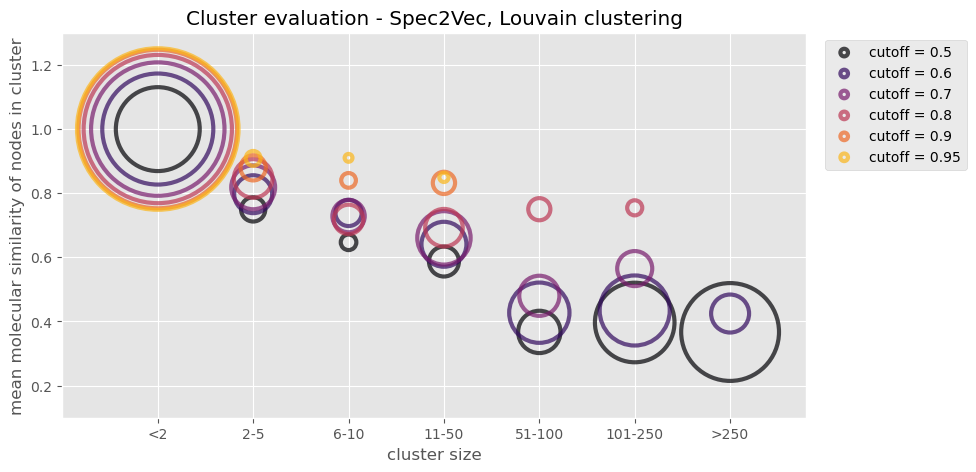

In [128]:
size_bins = [1,5,10,50,100,250, len(spectrums)]
labels_s2v = ['cutoff = ' + str(x) for x in thresholds]

plots_cluster_evaluations(DATA_s2v_louvain,
                          matrix_similarities_ref,
                          total_num_nodes,
                          size_bins,
                          labels_s2v,
                          title = 'Cluster evaluation - Spec2Vec, Louvain clustering',
                          filename = 'S2V_louvain_cluster_evaluation.pdf')

plt.ylim([0.1, 1.3])
plt.xlim([-1, 6.8])
plt.savefig('S2V_louvain_cluster_evaluation.pdf')

#### Evalute quality of clusters
This is here done by classifying clusters with a average molecular similarity score <0.4 as poor. And clusters with a a mean molecular similariy > 0.6 as well clustered.

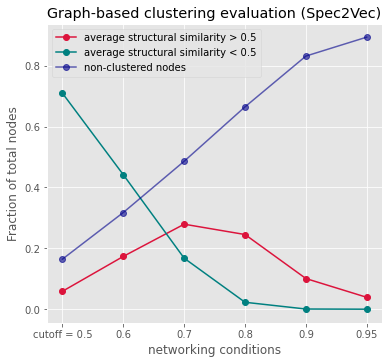

In [27]:
title = 'Graph-based clustering evaluation (Spec2Vec)'
labels_s2v = ['cutoff = ' + str(thresholds[0])] + [str(x) for x in thresholds[1:]]

plot_clustering_performance(DATA_s2v,
                            labels_s2v,
                            total_num_nodes,
                            thres_well = 0.5,
                            thres_poor = 0.5,
                            title = title,
                            filename = 'S2V_cluster_performance_thres05.pdf',
                            size_xy = (6,6))

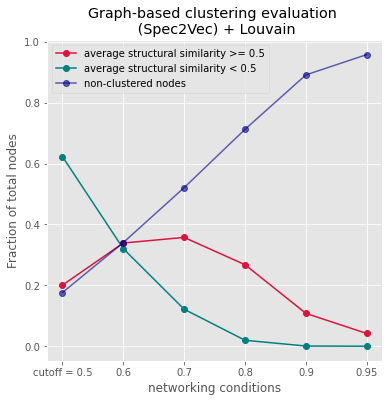

In [57]:
title = 'Graph-based clustering evaluation \n (Spec2Vec) + Louvain'
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
labels_s2v = ['cutoff = ' + str(thresholds[0])] + [str(x) for x in thresholds[1:]]

plot_clustering_performance(DATA_s2v_louvain,
                            labels_s2v,
                            thres_well = 0.5,
                            thres_poor = 0.5,
                            title = title,
                            filename = 'S2V_louvain_cluster_performance_thres05.pdf',
                            size_xy = (6,6))

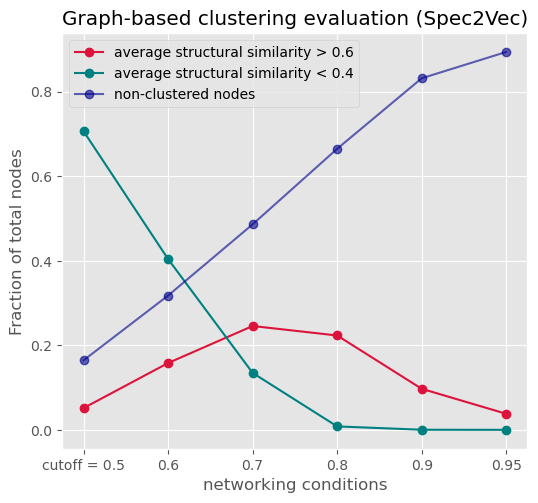

In [130]:
title = 'Graph-based clustering evaluation (Spec2Vec)'
labels_s2v = ['cutoff = ' + str(thresholds[0])] + [str(x) for x in thresholds[1:]]

plot_clustering_performance(DATA_s2v,
                            labels_s2v,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_cluster_performance.pdf',
                            size_xy = (6,6))

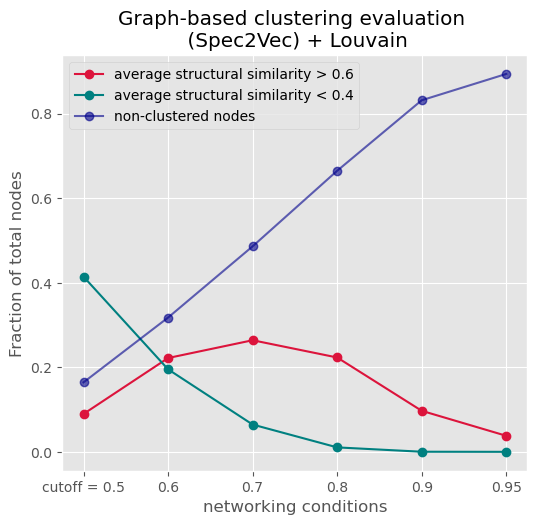

In [131]:
title = 'Graph-based clustering evaluation \n (Spec2Vec) + Louvain'
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
labels_s2v = ['cutoff = ' + str(thresholds[0])] + [str(x) for x in thresholds[1:]]

plot_clustering_performance(DATA_s2v_louvain,
                            labels_s2v,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_louvain_cluster_performance.pdf',
                            size_xy = (6,6))

# Make graph and export as graphml file

In [52]:
thres = 0.85

graph_s2v_085 = net.create_network(MS_library.list_similars_ctr_idx,
                                   MS_library.list_similars_ctr,
                                   max_links = 10,
                                   cutoff = thres,
                                   link_method = 'single')
    
graph_s2v_085_louvain, cluster_data_louvain = net.evaluate_clusters_louvain(graph_s2v_085,
                                                 M_sim_mol,
                                                 resolution = 1.0)

nx.write_graphml(graph_s2v_085_louvain, "graph_s2v_085_louvain.graphml")

In [55]:
cluster_data_louvain

,num_nodes,ref_sim_mean_nodes,ref_sim_var_nodes
0,1,1.000000,0.000000
1,41,0.429820,0.024991
2,2,0.838753,0.026000
3,1,1.000000,0.000000
4,53,0.583005,0.044459
...,...,...,...
6483,1,1.000000,0.000000
6484,1,1.000000,0.000000
6485,1,1.000000,0.000000
6486,1,1.000000,0.000000


In [54]:
# Add links by dilation step

graph_s2v_085_louvain_dil08, links_added = net.dilate_cluster(graph_s2v_085_louvain.copy(),
                                           MS_library.list_similars_ctr_idx,
                                           MS_library.list_similars_ctr,
                                           max_cluster_size = 90,   
                                           min_cluster_size = 10,
                                           max_per_cluster = None,
                                           min_weight = 0.8)

nx.write_graphml(graph_s2v_085_louvain_dil08, "graph_s2v_085_louvain_dil08.graphml")

# Direct comparison mod.cosine <-> spec2vec

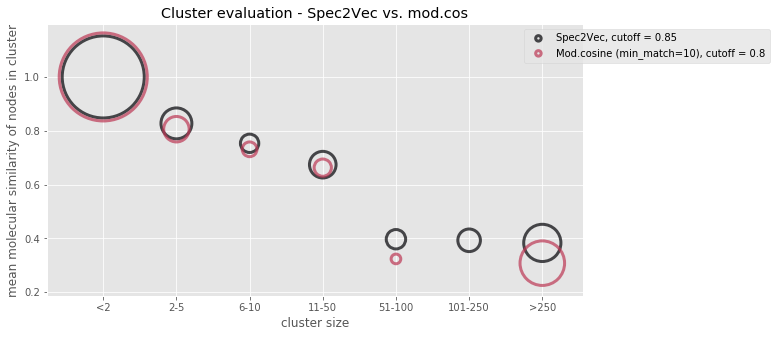

In [53]:
labels_compare = ['Spec2Vec, cutoff = 0.85','Mod.cosine (min_match=10), cutoff = 0.8']

plots_cluster_evaluations([DATA_s2v[3], DATA_modcos[2]],
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_compare,
                              title = 'Cluster evaluation - Spec2Vec vs. mod.cos',
                              filename = 'S2V_modcos_comparison_cluster_evaluation.pdf')


# Additional network trimming, filtering etc.

## Start with sparse network and add links ("dilation")
Here we start from a high cutoff (assuming this will mostly create reliable links).  
Then we run the **dilate_cluster()** function, which looks for possible additional links.  
The search will only consider nodes from small clusters (< min_cluster_size) and add the one highest link per node if it has a similarity/weight > min_weight.

In [ ]:
from networking import dilate_cluster

In [57]:
MSnet = net.create_network(MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_links = 10,
                           cutoff = 0.9,
                           link_method = 'single')

MSnet_dil, links_added = dilate_cluster(MSnet.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 200,   
                           min_cluster_size = 10,
                           max_per_node = 1,
                           max_per_cluster = None,
                           min_weight = 0.85)

MSnet_dil2, links_added = dilate_cluster(MSnet_dil.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.8)

MSnet_dil3, links_added = dilate_cluster(MSnet_dil2.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.8)

MSnet_dil4, links_added = dilate_cluster(MSnet_dil3.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.8)

MSnet_dil5, links_added = dilate_cluster(MSnet_dil4.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 20,   
                           min_cluster_size = 4,
                           max_per_cluster = None,
                           min_weight = 0.7)

In [58]:
DATA_dilation = []
DATA_dilation_louvain = []

for network in [MSnet, MSnet_dil, MSnet_dil2, MSnet_dil3, MSnet_dil4, MSnet_dil5]:
    cluster_data = net.evaluate_clusters(network,
                                     M_sim_mol)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network,
                                                     M_sim_mol,
                                                     resolution = 1.0)
    
    DATA_dilation.append(cluster_data)
    DATA_dilation_louvain.append(cluster_data_louvain)

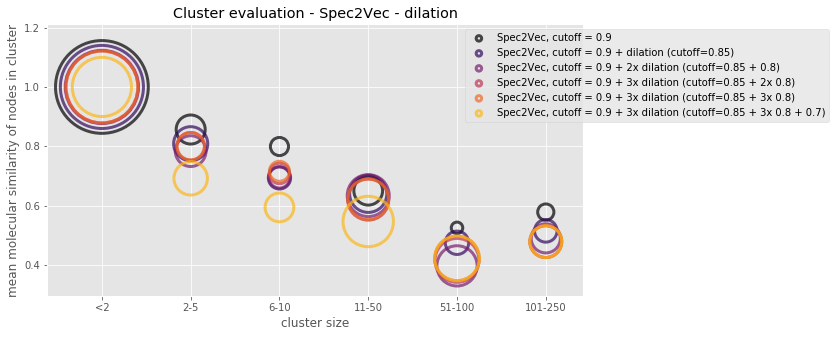

In [59]:
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_dilation = ['Spec2Vec, cutoff = 0.9',
                  'Spec2Vec, cutoff = 0.9 + dilation (cutoff=0.85)',
                 'Spec2Vec, cutoff = 0.9 + 2x dilation (cutoff=0.85 + 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 2x 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 3x 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 3x 0.8 + 0.7)']

plots_cluster_evaluations(DATA_dilation,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_dilation,
                              title = 'Cluster evaluation - Spec2Vec - dilation',
                              filename = 'S2V_dilation_cluster_evaluation.pdf')

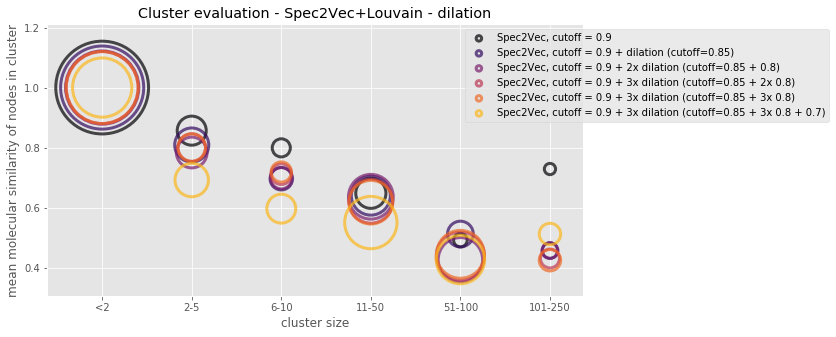

In [60]:
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_dilation = ['Spec2Vec, cutoff = 0.9',
                  'Spec2Vec, cutoff = 0.9 + dilation (cutoff=0.85)',
                 'Spec2Vec, cutoff = 0.9 + 2x dilation (cutoff=0.85 + 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 2x 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 3x 0.8)',
                 'Spec2Vec, cutoff = 0.9 + 3x dilation (cutoff=0.85 + 3x 0.8 + 0.7)']

plots_cluster_evaluations(DATA_dilation_louvain,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_dilation,
                              title = 'Cluster evaluation - Spec2Vec+Louvain - dilation',
                              filename = 'S2V_louvain_dilation_cluster_evaluation.pdf')

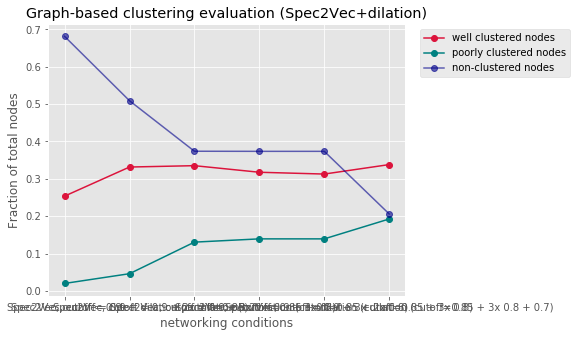

In [62]:
title = 'Graph-based clustering evaluation (Spec2Vec+dilation)'

plot_clustering_performance(DATA_dilation,
                            labels_dilation,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_dilation_cluster_performance.pdf')

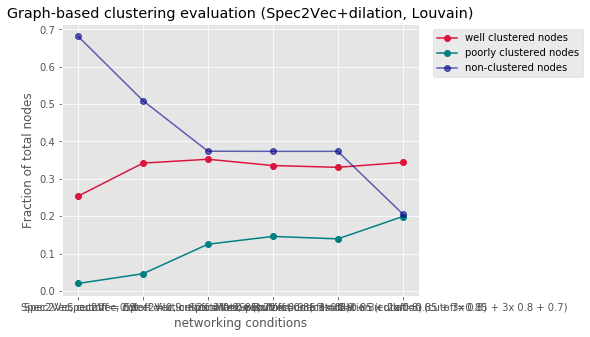

In [63]:
title = 'Graph-based clustering evaluation (Spec2Vec+dilation, Louvain)'

plot_clustering_performance(DATA_dilation_louvain,
                            labels_dilation,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_dilation_louvain_cluster_performance.pdf')

## Try dilation together with mod.cosine based networking
min_match=10, tol = 0.005

In [70]:
MSnet = net.create_network(molnet_similars_idx,
                           molnet_similars,
                           max_links = 10,
                           cutoff = 0.9,
                           link_method = 'single')

MSnet_dil, links_added = dilate_cluster(MSnet.copy(),
                           molnet_similars_idx,
                           molnet_similars,
                           max_cluster_size = 200,   
                           min_cluster_size = 10,
                           max_per_node = 1,
                           max_per_cluster = None,
                           min_weight = 0.85)

MSnet_dil2, links_added = dilate_cluster(MSnet_dil.copy(),
                           molnet_similars_idx,
                           molnet_similars,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.8)

MSnet_dil3, links_added = dilate_cluster(MSnet_dil2.copy(),
                           molnet_similars_idx,
                           molnet_similars,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.75)

MSnet_dil4, links_added = dilate_cluster(MSnet_dil3.copy(),
                           molnet_similars_idx,
                           molnet_similars,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.7)

MSnet_dil5, links_added = dilate_cluster(MSnet_dil4.copy(),
                           molnet_similars_idx,
                           molnet_similars,
                           max_cluster_size = 20,   
                           min_cluster_size = 4,
                           max_per_cluster = None,
                           min_weight = 0.65)

In [71]:
DATA_dilation = []
DATA_dilation_louvain = []

for network in [MSnet, MSnet_dil, MSnet_dil2, MSnet_dil3, MSnet_dil4, MSnet_dil5]:
    cluster_data = net.evaluate_clusters(network,
                                     M_sim_mol)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network,
                                                     M_sim_mol,
                                                     resolution = 1.0)
    
    DATA_dilation.append(cluster_data)
    DATA_dilation_louvain.append(cluster_data_louvain)

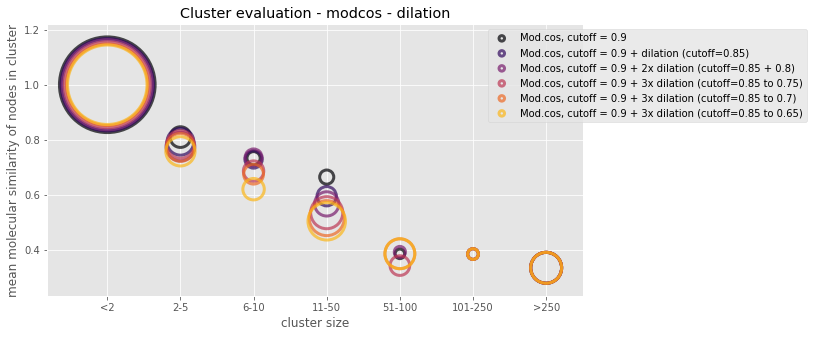

In [72]:
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_dilation = ['Mod.cos, cutoff = 0.9',
                  'Mod.cos, cutoff = 0.9 + dilation (cutoff=0.85)',
                 'Mod.cos, cutoff = 0.9 + 2x dilation (cutoff=0.85 + 0.8)',
                 'Mod.cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.75)',
                 'Mod.cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.7)',
                 'Mod.cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.65)']

plots_cluster_evaluations(DATA_dilation,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_dilation,
                              title = 'Cluster evaluation - modcos - dilation',
                              filename = 'modcos_dilation_cluster_evaluation.pdf')

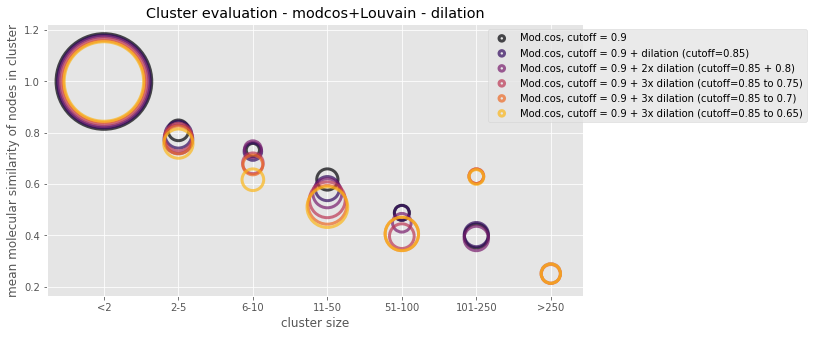

In [73]:
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_dilation = ['Mod.cos, cutoff = 0.9',
                  'Mod.cos, cutoff = 0.9 + dilation (cutoff=0.85)',
                 'Mod.cos, cutoff = 0.9 + 2x dilation (cutoff=0.85 + 0.8)',
                 'Mod.cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.75)',
                 'Mod.cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.7)',
                 'Mod.cos, cutoff = 0.9 + 3x dilation (cutoff=0.85 to 0.65)']

plots_cluster_evaluations(DATA_dilation_louvain,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_dilation,
                              title = 'Cluster evaluation - modcos+Louvain - dilation',
                              filename = 'modcos_louvain_dilation_cluster_evaluation.pdf')

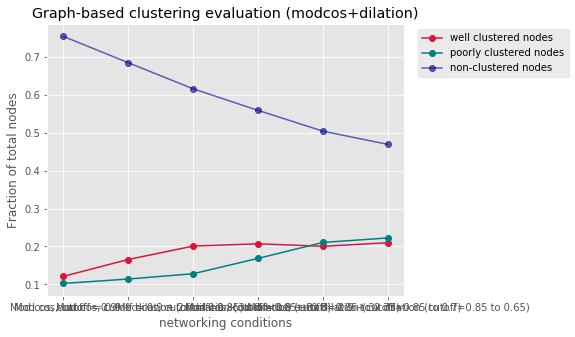

In [74]:
title = 'Graph-based clustering evaluation (modcos+dilation)'

plot_clustering_performance(DATA_dilation,
                            labels_dilation,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'modcos_dilation_cluster_performance.pdf')

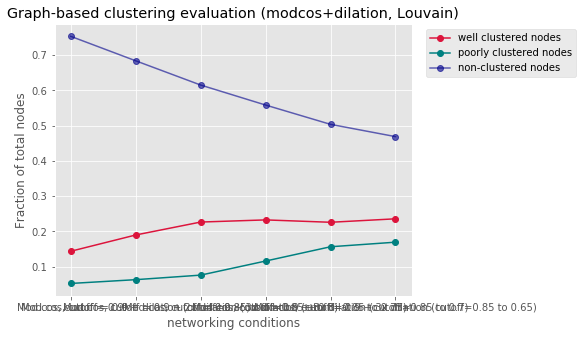

In [75]:
title = 'Graph-based clustering evaluation (modcos+dilation, Louvain)'

plot_clustering_performance(DATA_dilation_louvain,
                            labels_dilation,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'modcos_dilation_louvain_cluster_performance.pdf')

## Another test based on Spec2Vec

In [76]:
MSnet = net.create_network(MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_links = 10,
                           cutoff = 0.9,
                           link_method = 'single')

MSnet_dil, links_added = dilate_cluster(MSnet.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 200,   
                           min_cluster_size = 10,
                           max_per_node = 1,
                           max_per_cluster = None,
                           min_weight = 0.85)

MSnet_dil2, links_added = dilate_cluster(MSnet.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.75)

MSnet_dil3, links_added = dilate_cluster(MSnet_dil.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.85)

MSnet_dil4, links_added = dilate_cluster(MSnet_dil.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 90,   
                           min_cluster_size = 10,
                           max_per_cluster = None,
                           min_weight = 0.8)

MSnet_dil5, links_added = dilate_cluster(MSnet_dil.copy(),
                           MS_library.list_similars_ctr_idx,
                           MS_library.list_similars_ctr,
                           max_cluster_size = 20,   
                           min_cluster_size = 4,
                           max_per_cluster = None,
                           min_weight = 0.7)

In [77]:
DATA_dilation = []
DATA_dilation_louvain = []

for network in [MSnet, MSnet_dil, MSnet_dil2, MSnet_dil3, MSnet_dil4, MSnet_dil5]:
    cluster_data = net.evaluate_clusters(network,
                                     M_sim_mol)
    
    _, cluster_data_louvain = net.evaluate_clusters_louvain(network,
                                                     M_sim_mol,
                                                     resolution = 1.0)
    
    DATA_dilation.append(cluster_data)
    DATA_dilation_louvain.append(cluster_data_louvain)

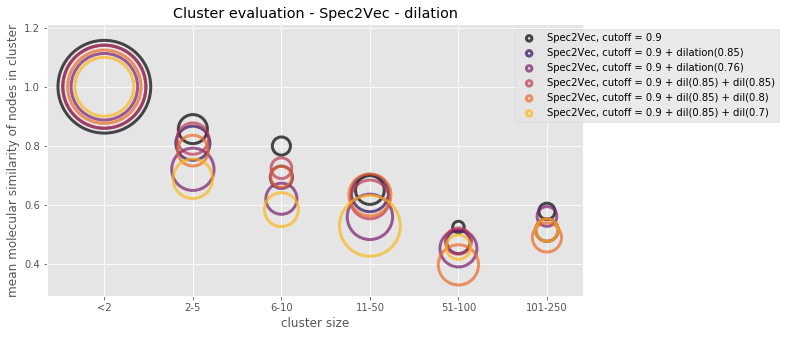

In [78]:
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_dilation = ['Spec2Vec, cutoff = 0.9',
                  'Spec2Vec, cutoff = 0.9 + dilation(0.85)',
                 'Spec2Vec, cutoff = 0.9 + dilation(0.76)',
                 'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.85)',
                 'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.8)',
                 'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.7)']

plots_cluster_evaluations(DATA_dilation,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_dilation,
                              title = 'Cluster evaluation - Spec2Vec - dilation',
                              filename = 'S2V_dilation_cluster_evaluation2.pdf')

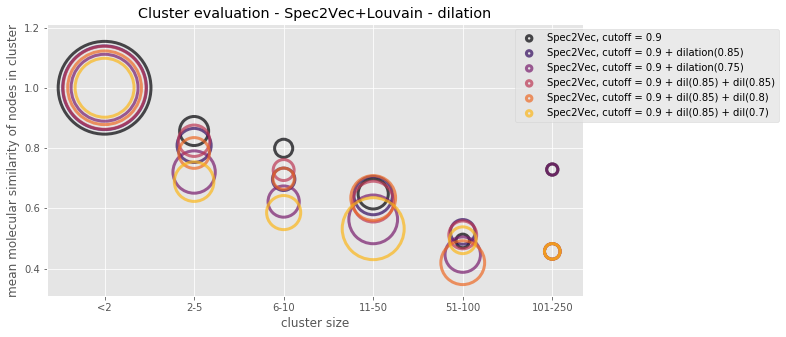

In [83]:
size_bins = [1,5,10,50,100,250, len(spectra)]
labels_dilation = ['Spec2Vec, cutoff = 0.9',
                  'Spec2Vec, cutoff = 0.9 + dilation(0.85)',
                 'Spec2Vec, cutoff = 0.9 + dilation(0.75)',
                 'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.85)',
                 'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.8)',
                 'Spec2Vec, cutoff = 0.9 + dil(0.85) + dil(0.7)']

plots_cluster_evaluations(DATA_dilation_louvain,
                              M_sim_mol,
                              total_num_nodes,
                              size_bins,
                              labels_dilation,
                              title = 'Cluster evaluation - Spec2Vec+Louvain - dilation',
                              filename = 'S2V_louvain_dilation_cluster_evaluation2.pdf')

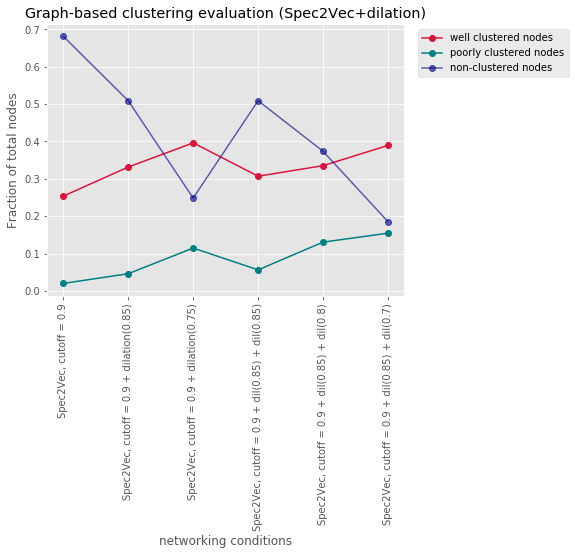

In [84]:
title = 'Graph-based clustering evaluation (Spec2Vec+dilation)'

plot_clustering_performance(DATA_dilation,
                            labels_dilation,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_dilation_cluster_performance2.pdf')
plt.xticks(labels_dilation, rotation='vertical')
plt.savefig('S2V_dilation_cluster_performance2.pdf', dpi=600)

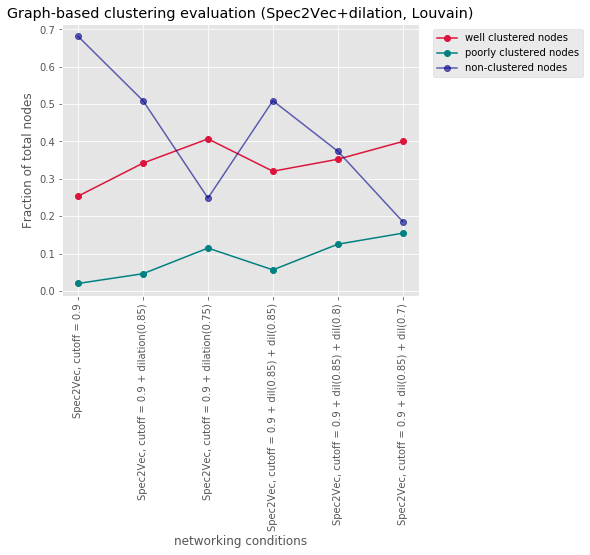

In [88]:
title = 'Graph-based clustering evaluation (Spec2Vec+dilation, Louvain)'

plot_clustering_performance(DATA_dilation_louvain,
                            labels_dilation,
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_dilation_louvain_cluster_performance2.pdf')
plt.xticks(labels_dilation, rotation='vertical')
plt.savefig('S2V_dilation_louvain_cluster_performance2.pdf', dpi=600)

# Visualize what add_intra_cluster_links() function does:
Which essentially shows a bit that measures like density and transitivity (connectedness) are very sensitive to parameter choices!

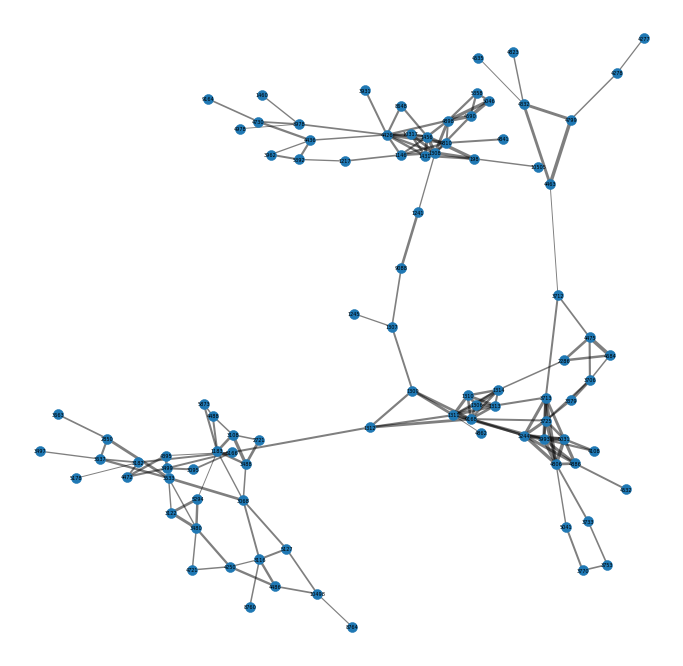

In [377]:
cm = plt.cm.get_cmap('gray')

G = graphs[167]
def plot_cluster(G):
    if len(G.nodes) > 1:
        edges = [(u, v) for (u, v, d) in G.edges(data=True) ]
        weights = [d['weight'] for (u, v, d) in G.edges(data=True) ]
        weights = weights - 0.95*np.min(weights)
        weights = weights/np.max(weights)

        pos = nx.spring_layout(G)  # positions for all nodes
        plt.figure(figsize=(12,12))
        # nodes
        nx.draw_networkx_nodes(G, pos, node_size=100)

        # edges
        nx.draw_networkx_edges(G, pos, edgelist=edges, width=4*weights, alpha=0.5)

        # labels
        nx.draw_networkx_labels(G, pos, font_size=5, font_family='sans-serif')

        plt.axis('off')
        plt.show()
        
plot_cluster(G)

In [394]:
MSnet_dil4_2 = net.add_intra_cluster_links(MSnet_dil4.copy(),
                           M_sim_mol, 
                           min_weight = 0.7)

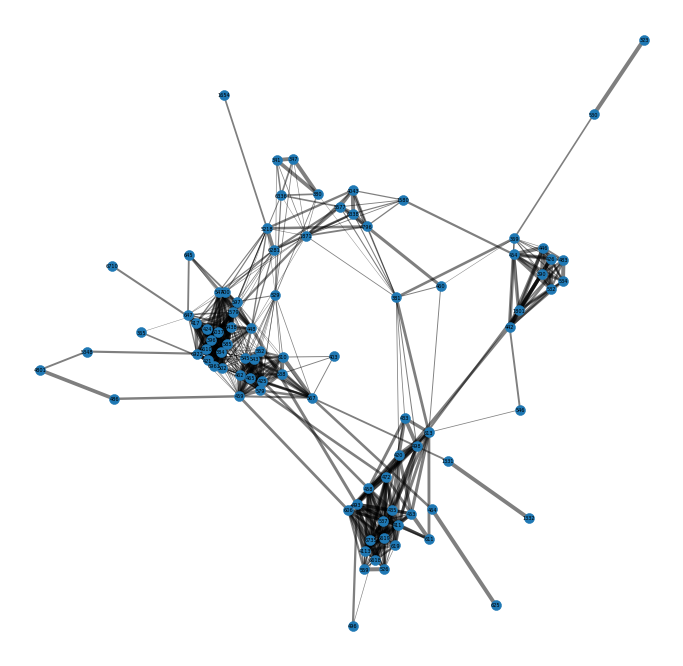

density: 0.14382022471910114
transitivity: 0.7207055858882823


In [396]:
G = graphs[selection[16]]
plot_cluster(graphs[selection[16]])
print('density:', nx.density(G))
print('transitivity:', nx.transitivity(G))

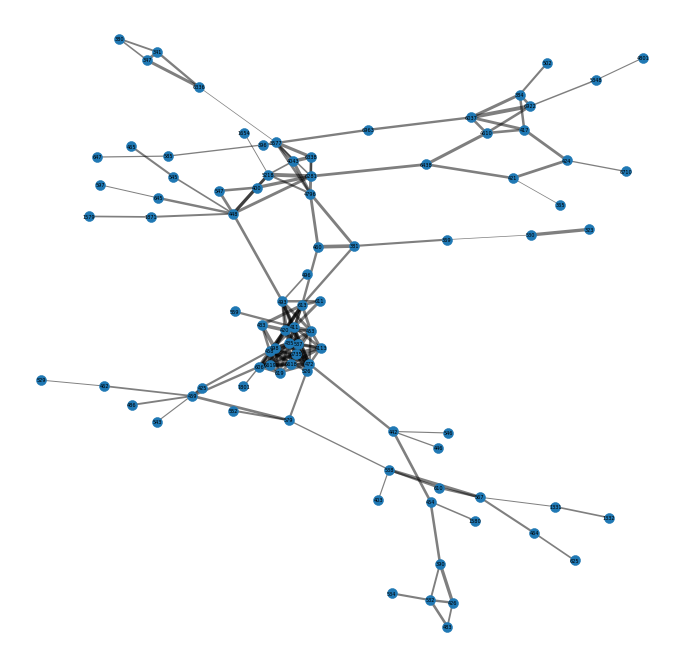

density: 0.04519350811485643
transitivity: 0.5152057245080501


In [386]:
G = graphs[selection[16]]
plot_cluster(graphs[selection[16]])
print('density:', nx.density(G))
print('transitivity:', nx.transitivity(G))

In [90]:
MSnet_dil2_added = net.add_intra_cluster_links(MSnet_dil2.copy(),
                                       M_sim_mol, 
                                       min_weight = 0.7)

In [91]:
cluster_data = net.evaluate_clusters(MSnet_dil2_added,
                                 M_sim_mol)

_, cluster_data_louvain = net.evaluate_clusters_louvain(MSnet_dil2_added,
                                                 M_sim_mol,
                                                 resolution = 1.0)

DATA_dilation.append(cluster_data)
DATA_dilation_louvain.append(cluster_data_louvain)

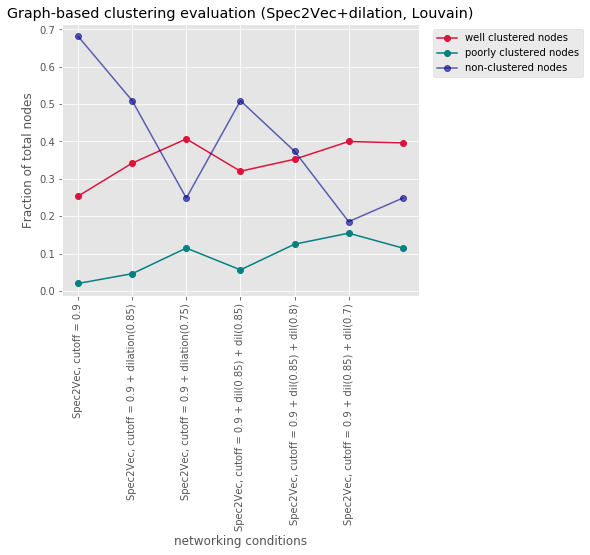

In [92]:
title = 'Graph-based clustering evaluation (Spec2Vec+dilation, Louvain)'

plot_clustering_performance(DATA_dilation_louvain,
                            labels_dilation + ['added links to dil(0.75)'],
                            total_num_nodes,
                            thres_well = 0.6,
                            thres_poor = 0.4,
                            title = title,
                            filename = 'S2V_dilation_louvain_cluster_performance2.pdf')
plt.xticks(labels_dilation, rotation='vertical')
plt.savefig('S2V_dilation_louvain_cluster_performance3.pdf', dpi=600)

# Some former tests and playing around...

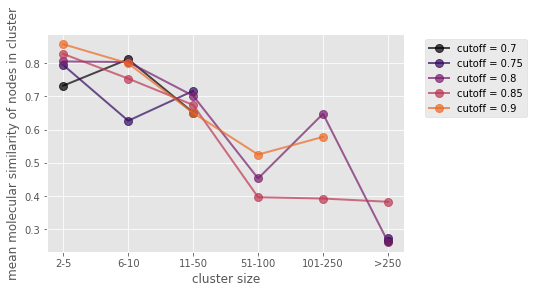

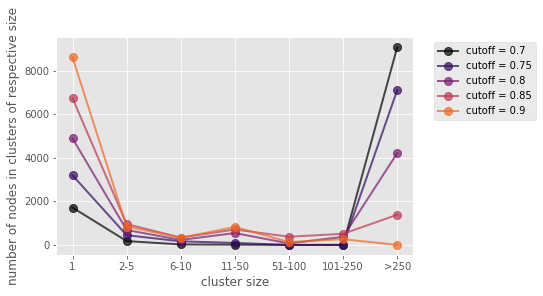

In [37]:


import matplotlib.colors as colors
import matplotlib.cm as cmx
cm = plt.get_cmap('inferno') #'jet' 
cNorm  = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)

fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)
for i, [num_elements, mean_edge_sim, mean_node_sim] in enumerate(plots):
    colorVal = scalarMap.to_rgba(i/(len(plots)+1))
    plt.plot(x_labels, mean_node_sim, 'o-', alpha= 0.7, lw=2, markersize=8, 
             color= colorVal, label=labels[i])
    plt.xlabel('cluster size')
    plt.ylabel('mean molecular similarity of nodes in cluster')   
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.8, chartBox.height])
lgnd = ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1))
for i in range(len(plots)):
    lgnd.legendHandles[i]._sizes = [30]

fig = plt.figure(figsize=(8,4))
ax = plt.subplot(111)
for i, [num_elements, mean_edge_sim, mean_node_sim] in enumerate(plots):
    colorVal = scalarMap.to_rgba(i/(len(plots)+1))
    plt.plot(x_labels, num_elements, 'o-', alpha= 0.7, lw=2, markersize=8, 
             color= colorVal, label=labels[i])
    plt.xlabel('cluster size')
    plt.ylabel('number of nodes in clusters of respective size')
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.8, chartBox.height])
lgnd = ax.legend(loc='upper center', bbox_to_anchor=(1.2, 1))
for i in range(len(plots)):
    lgnd.legendHandles[i]._sizes = [30]

In [50]:
cluster_data = evaluate_clusters(MSnet1,
                                     M_sim_mol)

In [51]:
cluster_data.head(10)

,num_nodes,num_edges,ref_sim_mean_edges,ref_sim_var_edges,ref_sim_mean_nodes,ref_sim_var_nodes
0,9074,43864,0.523674,0.077106,0.264760,0.018677
1,1,0,0.000000,0.000000,1.000000,0.000000
2,1,0,0.000000,0.000000,1.000000,0.000000
3,3,2,0.448009,0.068529,0.577687,0.128484
4,1,0,0.000000,0.000000,1.000000,0.000000
5,1,0,0.000000,0.000000,1.000000,0.000000
6,1,0,0.000000,0.000000,1.000000,0.000000
7,1,0,0.000000,0.000000,1.000000,0.000000
8,1,0,0.000000,0.000000,1.000000,0.000000
9,1,0,0.000000,0.000000,1.000000,0.000000


Text(0, 0.5, 'cluster size')

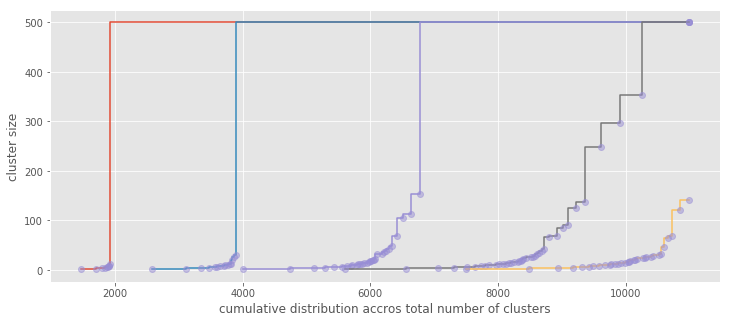

In [105]:
networks = [MSnet1, MSnet2, MSnet3, MSnet4, MSnet5]
y_max = 500
    
""" Run evaluation and series of plots.
"""
size_bins = [1,5,10,50,100,250, len(spectra)]
bins = [0] + [x+1 for x in size_bins]
x_labels = ['1', '2-5', '6-10', '11-50', '51-100', '101-250', '>250']
plt.style.use('ggplot')

data_collection = []
for network in networks:
    cluster_data = evaluate_clusters(network,
                                     M_sim_mol)
    
    data_collection.append(cluster_data)

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111)
for cluster_data in data_collection:    

    cum_dist = []
    cluster_sizes_unique = cluster_data.sort_values(by=('num_nodes'))['num_nodes'].unique()
    for cluster_size in cluster_sizes_unique:
        num_elements = cluster_size * np.sum(cluster_data['num_nodes'] == cluster_size)
        cum_dist.append((cluster_size, num_elements))
    y,x = np.array(list((zip(*cum_dist))))
    y[y>y_max] = y_max
    x_cum = [np.sum(x[:(i+1)]) for i in range(len(x))]
    plt.step(x_cum, y, where='pre', label='post')
    plt.plot(x_cum, y, 'C2o', alpha=0.5)    

plt.xlabel('cumulative distribution accros total number of clusters')
plt.ylabel('cluster size')